In [1]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D, Activation, Lambda, Add, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.regularizers import l2
import keras.backend as K

from utils import plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features
from oct_conv2d import OctConv2D

Using TensorFlow backend.


# Parameters

In [2]:
train_dir = 'dogs_32/train/'
validation_dir = 'dogs_32/validation/'
test_dir = 'dogs_32/test/'

STD_SIZE = (32, 32)
BATCH_SIZE = 128
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

In [37]:
def lr_scheduler(epoch):
    x = 1e-4
    if epoch >= 50: x /= 10.0
    if epoch >= 100: x /= 10.0
    if epoch >= 150: x /= 10.0
    return x

# Data preparation

In [34]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

Found 8065 images belonging to 60 classes.
Found 2046 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_dog', 'Great_Dane', 'Great_Pyrenees', 'groene

# Baseline

## Model

In [35]:
inputs = Input(shape=(32, 32, 3))
y = Conv2D(192, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(inputs)
y = Conv2D(160, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(96, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(y)
y = Conv2D(192, (5, 5), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(192, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(192, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(y)
y = Conv2D(192, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(192, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
y = Conv2D(60, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(1e-4))(y)
outputs = GlobalAveragePooling2D()(y)
outputs = Activation('softmax')(outputs)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-3),
              metrics=['accuracy'])

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 32, 32, 192)       14592     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 32, 32, 160)       30880     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 32, 32, 96)        15456     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 16, 16, 192)       460992    
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 16, 16, 192)       37056     
__________

In [38]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'nin_dogs_alpha_0', monitor='val_acc', save_best_only=True, verbose=1),
               LearningRateScheduler(lr_scheduler)
              ])

with open(PATH + 'nin_dogs_alpha_0_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
 - 13s - loss: 4.2099 - acc: 0.0211 - val_loss: 4.1987 - val_acc: 0.0229

Epoch 00001: val_acc improved from -inf to 0.02292, saving model to nin_dogs_alpha_0
Epoch 2/100
 - 12s - loss: 4.1912 - acc: 0.0234 - val_loss: 4.1814 - val_acc: 0.0229

Epoch 00002: val_acc improved from 0.02292 to 0.02294, saving model to nin_dogs_alpha_0
Epoch 3/100
 - 12s - loss: 4.1764 - acc: 0.0231 - val_loss: 4.1715 - val_acc: 0.0214

Epoch 00003: val_acc did not improve from 0.02294
Epoch 4/100
 - 12s - loss: 4.1654 - acc: 0.0234 - val_loss: 4.1572 - val_acc: 0.0276

Epoch 00004: val_acc improved from 0.02294 to 0.02763, saving model to nin_dogs_alpha_0
Epoch 5/100
 - 12s - loss: 4.1553 - acc: 0.0237 - val_loss: 4.1495 - val_acc: 0.0229

Epoch 00005: val_acc did not improve from 0.02763
Epoch 6/100
 - 12s - loss: 4.1474 - acc: 0.0233 - val_loss: 4.1467 - val_acc: 0.0198

Epoch 00006: val_acc did not improve from 0.02763
Epoch 7/100
 - 12s - loss: 4.1412 - acc: 0.0229 - val_loss: 4.1334 - val_


Epoch 00057: val_acc did not improve from 0.05005
Epoch 58/100
 - 12s - loss: 4.0277 - acc: 0.0549 - val_loss: 4.0257 - val_acc: 0.0448

Epoch 00058: val_acc did not improve from 0.05005
Epoch 59/100
 - 12s - loss: 4.0271 - acc: 0.0594 - val_loss: 4.0229 - val_acc: 0.0480

Epoch 00059: val_acc did not improve from 0.05005
Epoch 60/100
 - 12s - loss: 4.0296 - acc: 0.0553 - val_loss: 4.0165 - val_acc: 0.0438

Epoch 00060: val_acc did not improve from 0.05005
Epoch 61/100
 - 12s - loss: 4.0305 - acc: 0.0577 - val_loss: 4.0242 - val_acc: 0.0438

Epoch 00061: val_acc did not improve from 0.05005
Epoch 62/100
 - 12s - loss: 4.0268 - acc: 0.0556 - val_loss: 4.0184 - val_acc: 0.0532

Epoch 00062: val_acc improved from 0.05005 to 0.05318, saving model to nin_dogs_alpha_0
Epoch 63/100
 - 12s - loss: 4.0270 - acc: 0.0584 - val_loss: 4.0274 - val_acc: 0.0485

Epoch 00063: val_acc did not improve from 0.05318
Epoch 64/100
 - 12s - loss: 4.0261 - acc: 0.0562 - val_loss: 4.0091 - val_acc: 0.0532

Ep

### Results

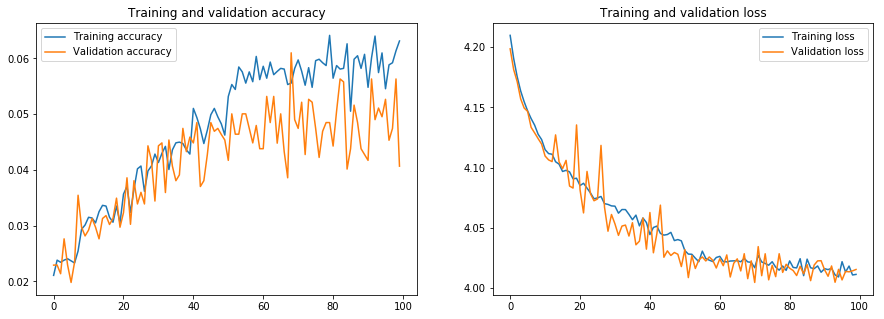

In [39]:
plot_accuracy_and_loss(history.history)

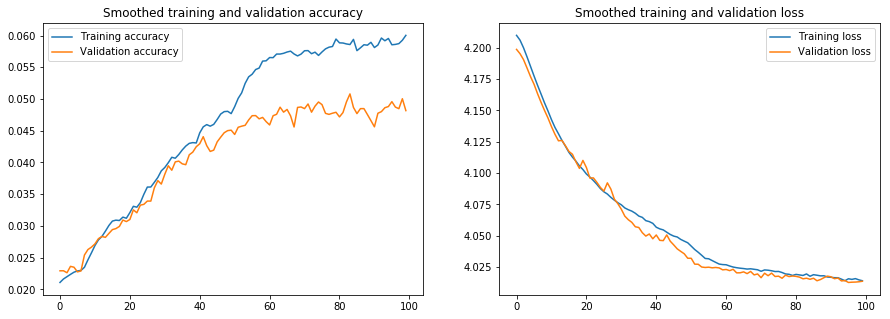

In [40]:
plot_smoothed_acc_and_loss(history.history, 0.8)

In [41]:
model = load_model(PATH + 'nin_dogs_alpha_0')
model.evaluate(test_features, test_labels)

2046/2046 [==============================] - 2s 819us/step


[4.013540664143343, 0.053274682332431114]

# OctConv

## Model

In [42]:
for alpha in [0.125, 0.25, 0.5, 0.75]:
    inputs = Input(shape=(32, 32, 3))
    low = AveragePooling2D(2)(inputs)
    
    high, low = OctConv2D(filters=192, kernel_size=(5, 5), alpha=alpha, kernel_regularizer=l2(1e-4))([inputs, low])
    high, low = Activation('relu')(high), Activation('relu')(low)  
    high, low = OctConv2D(filters=160, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=96, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=192, kernel_size=(5, 5), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)  
    high, low = OctConv2D(filters=192, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=192, kernel_size=(1, 1), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=192, kernel_size=(3, 3), alpha=alpha, kernel_regularizer=l2(1e-4))([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)  
            
    high = Conv2D(192, padding='same', kernel_size=(1, 1), kernel_regularizer=l2(1e-4))(high)
    low = Conv2D(192, padding='same', kernel_size=(1, 1), kernel_regularizer=l2(1e-4))(low)
    low = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(low)
    x = Add()([high, low])
    x = Activation('relu')(x)
    
    x = Conv2D(filters=60, kernel_size=(1, 1), kernel_regularizer=l2(1e-4))(x)
    
    x = GlobalAveragePooling2D()(x)
    outputs = Activation('softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=1e-4),
                  metrics=['accuracy'])
    history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + f'nin_dogs_alpha_{alpha}', monitor='val_acc', save_best_only=True, verbose=1),
               LearningRateScheduler(lr_scheduler)
              ])

    with open(PATH + f'nin_dogs_alpha_{alpha}_history', 'wb') as f:
        pickle.dump(history.history, f)

W0718 22:00:31.659550  1284 deprecation_wrapper.py:119] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0718 22:00:31.664551  1284 deprecation.py:506] From c:\users\serphone\envs\ds_libs_tuto\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/100
 - 26s - loss: 4.2588 - acc: 0.0218 - val_loss: 4.2474 - val_acc: 0.0261

Epoch 00001: val_acc improved from -inf to 0.02607, saving model to nin_dogs_alpha_0.125
Epoch 2/100
 - 21s - loss: 4.2408 - acc: 0.0227 - val_loss: 4.2282 - val_acc: 0.0209

Epoch 00002: val_acc did not improve from 0.02607
Epoch 3/100
 - 21s - loss: 4.2206 - acc: 0.0265 - val_loss: 4.2043 - val_acc: 0.0282

Epoch 00003: val_acc improved from 0.02607 to 0.02815, saving model to nin_dogs_alpha_0.125
Epoch 4/100
 - 21s - loss: 4.1936 - acc: 0.0305 - val_loss: 4.1578 - val_acc: 0.0375

Epoch 00004: val_acc improved from 0.02815 to 0.03754, saving model to nin_dogs_alpha_0.125
Epoch 5/100
 - 21s - loss: 4.1497 - acc: 0.0339 - val_loss: 4.1229 - val_acc: 0.0386

Epoch 00005: val_acc improved from 0.03754 to 0.03858, saving model to nin_dogs_alpha_0.125
Epoch 6/100
 - 21s - loss: 4.1283 - acc: 0.0357 - val_loss: 4.0956 - val_acc: 0.0370

Epoch 00006: val_acc did not improve from 0.03858
Epoch 7/100
 - 21s 


Epoch 00055: val_acc did not improve from 0.11210
Epoch 56/100
 - 21s - loss: 3.6611 - acc: 0.1110 - val_loss: 3.6527 - val_acc: 0.1125

Epoch 00056: val_acc improved from 0.11210 to 0.11250, saving model to nin_dogs_alpha_0.125
Epoch 57/100
 - 21s - loss: 3.6879 - acc: 0.1016 - val_loss: 3.6739 - val_acc: 0.0996

Epoch 00057: val_acc did not improve from 0.11250
Epoch 58/100
 - 21s - loss: 3.6399 - acc: 0.1141 - val_loss: 3.6595 - val_acc: 0.1058

Epoch 00058: val_acc did not improve from 0.11250
Epoch 59/100
 - 21s - loss: 3.6741 - acc: 0.1011 - val_loss: 3.6461 - val_acc: 0.1152

Epoch 00059: val_acc improved from 0.11250 to 0.11522, saving model to nin_dogs_alpha_0.125
Epoch 60/100
 - 21s - loss: 3.6775 - acc: 0.1042 - val_loss: 3.6869 - val_acc: 0.1038

Epoch 00060: val_acc did not improve from 0.11522
Epoch 61/100
 - 21s - loss: 3.6633 - acc: 0.1032 - val_loss: 3.6417 - val_acc: 0.1043

Epoch 00061: val_acc did not improve from 0.11522
Epoch 62/100
 - 21s - loss: 3.6694 - acc: 0


Epoch 00012: val_acc improved from 0.05266 to 0.05683, saving model to nin_dogs_alpha_0.25
Epoch 13/100
 - 19s - loss: 4.0098 - acc: 0.0520 - val_loss: 3.9748 - val_acc: 0.0464

Epoch 00013: val_acc did not improve from 0.05683
Epoch 14/100
 - 19s - loss: 3.9901 - acc: 0.0551 - val_loss: 4.2158 - val_acc: 0.0318

Epoch 00014: val_acc did not improve from 0.05683
Epoch 15/100
 - 19s - loss: 3.9818 - acc: 0.0583 - val_loss: 3.9264 - val_acc: 0.0625

Epoch 00015: val_acc improved from 0.05683 to 0.06250, saving model to nin_dogs_alpha_0.25
Epoch 16/100
 - 19s - loss: 3.9544 - acc: 0.0553 - val_loss: 3.9566 - val_acc: 0.0537

Epoch 00016: val_acc did not improve from 0.06250
Epoch 17/100
 - 19s - loss: 3.9749 - acc: 0.0597 - val_loss: 3.9742 - val_acc: 0.0605

Epoch 00017: val_acc did not improve from 0.06250
Epoch 18/100
 - 19s - loss: 3.9494 - acc: 0.0589 - val_loss: 3.9221 - val_acc: 0.0620

Epoch 00018: val_acc did not improve from 0.06250
Epoch 19/100
 - 19s - loss: 3.9363 - acc: 0.0

 - 19s - loss: 3.6527 - acc: 0.1166 - val_loss: 3.6288 - val_acc: 0.1121

Epoch 00070: val_acc did not improve from 0.11940
Epoch 71/100
 - 19s - loss: 3.6042 - acc: 0.1320 - val_loss: 3.6202 - val_acc: 0.1142

Epoch 00071: val_acc did not improve from 0.11940
Epoch 72/100
 - 19s - loss: 3.6244 - acc: 0.1154 - val_loss: 3.6165 - val_acc: 0.1121

Epoch 00072: val_acc did not improve from 0.11940
Epoch 73/100
 - 19s - loss: 3.6099 - acc: 0.1121 - val_loss: 3.6468 - val_acc: 0.1163

Epoch 00073: val_acc did not improve from 0.11940
Epoch 74/100
 - 19s - loss: 3.6187 - acc: 0.1177 - val_loss: 3.6328 - val_acc: 0.1017

Epoch 00074: val_acc did not improve from 0.11940
Epoch 75/100
 - 19s - loss: 3.6147 - acc: 0.1176 - val_loss: 3.5902 - val_acc: 0.1194

Epoch 00075: val_acc improved from 0.11940 to 0.11940, saving model to nin_dogs_alpha_0.25
Epoch 76/100
 - 19s - loss: 3.6367 - acc: 0.1204 - val_loss: 3.6296 - val_acc: 0.1095

Epoch 00076: val_acc did not improve from 0.11940
Epoch 77/100



Epoch 00026: val_acc did not improve from 0.08081
Epoch 27/100
 - 14s - loss: 3.8860 - acc: 0.0736 - val_loss: 3.8367 - val_acc: 0.0819

Epoch 00027: val_acc improved from 0.08081 to 0.08186, saving model to nin_dogs_alpha_0.5
Epoch 28/100
 - 14s - loss: 3.9190 - acc: 0.0758 - val_loss: 3.7916 - val_acc: 0.0965

Epoch 00028: val_acc improved from 0.08186 to 0.09645, saving model to nin_dogs_alpha_0.5
Epoch 29/100
 - 14s - loss: 3.8665 - acc: 0.0810 - val_loss: 3.7819 - val_acc: 0.1011

Epoch 00029: val_acc improved from 0.09645 to 0.10115, saving model to nin_dogs_alpha_0.5
Epoch 30/100
 - 14s - loss: 3.8529 - acc: 0.0738 - val_loss: 3.7848 - val_acc: 0.0928

Epoch 00030: val_acc did not improve from 0.10115
Epoch 31/100
 - 14s - loss: 3.8616 - acc: 0.0749 - val_loss: 3.7634 - val_acc: 0.0980

Epoch 00031: val_acc did not improve from 0.10115
Epoch 32/100
 - 14s - loss: 3.8483 - acc: 0.0817 - val_loss: 3.7836 - val_acc: 0.0845

Epoch 00032: val_acc did not improve from 0.10115
Epoch 3

 - 14s - loss: 3.6174 - acc: 0.1213 - val_loss: 3.5668 - val_acc: 0.1168

Epoch 00084: val_acc did not improve from 0.12513
Epoch 85/100
 - 14s - loss: 3.6180 - acc: 0.1228 - val_loss: 3.5876 - val_acc: 0.1168

Epoch 00085: val_acc did not improve from 0.12513
Epoch 86/100
 - 14s - loss: 3.6285 - acc: 0.1271 - val_loss: 3.5985 - val_acc: 0.1182

Epoch 00086: val_acc did not improve from 0.12513
Epoch 87/100
 - 14s - loss: 3.6111 - acc: 0.1197 - val_loss: 3.5915 - val_acc: 0.1116

Epoch 00087: val_acc did not improve from 0.12513
Epoch 88/100
 - 14s - loss: 3.6055 - acc: 0.1214 - val_loss: 3.5687 - val_acc: 0.1168

Epoch 00088: val_acc did not improve from 0.12513
Epoch 89/100
 - 14s - loss: 3.6134 - acc: 0.1193 - val_loss: 3.5922 - val_acc: 0.1126

Epoch 00089: val_acc did not improve from 0.12513
Epoch 90/100
 - 14s - loss: 3.6141 - acc: 0.1212 - val_loss: 3.5787 - val_acc: 0.1220

Epoch 00090: val_acc did not improve from 0.12513
Epoch 91/100
 - 14s - loss: 3.5637 - acc: 0.1381 - val

 - 10s - loss: 3.7565 - acc: 0.0896 - val_loss: 3.7033 - val_acc: 0.1048

Epoch 00039: val_acc improved from 0.10167 to 0.10480, saving model to nin_dogs_alpha_0.75
Epoch 40/100
 - 10s - loss: 3.7795 - acc: 0.0912 - val_loss: 3.8790 - val_acc: 0.0740

Epoch 00040: val_acc did not improve from 0.10480
Epoch 41/100
 - 10s - loss: 3.7541 - acc: 0.0934 - val_loss: 3.6878 - val_acc: 0.0991

Epoch 00041: val_acc did not improve from 0.10480
Epoch 42/100
 - 10s - loss: 3.7626 - acc: 0.0950 - val_loss: 3.6561 - val_acc: 0.1038

Epoch 00042: val_acc did not improve from 0.10480
Epoch 43/100
 - 10s - loss: 3.7610 - acc: 0.0922 - val_loss: 3.7394 - val_acc: 0.0886

Epoch 00043: val_acc did not improve from 0.10480
Epoch 44/100
 - 10s - loss: 3.7355 - acc: 0.0966 - val_loss: 3.6940 - val_acc: 0.0996

Epoch 00044: val_acc did not improve from 0.10480
Epoch 45/100
 - 10s - loss: 3.7358 - acc: 0.0977 - val_loss: 3.6645 - val_acc: 0.1021

Epoch 00045: val_acc did not improve from 0.10480
Epoch 46/100



Epoch 00097: val_acc did not improve from 0.13452
Epoch 98/100
 - 10s - loss: 3.5960 - acc: 0.1274 - val_loss: 3.5847 - val_acc: 0.1288

Epoch 00098: val_acc did not improve from 0.13452
Epoch 99/100
 - 10s - loss: 3.5761 - acc: 0.1254 - val_loss: 3.5523 - val_acc: 0.1246

Epoch 00099: val_acc did not improve from 0.13452
Epoch 100/100
 - 10s - loss: 3.5604 - acc: 0.1369 - val_loss: 3.5674 - val_acc: 0.1184

Epoch 00100: val_acc did not improve from 0.13452


For alpha = 0:
 Max test accuracy = 0.061



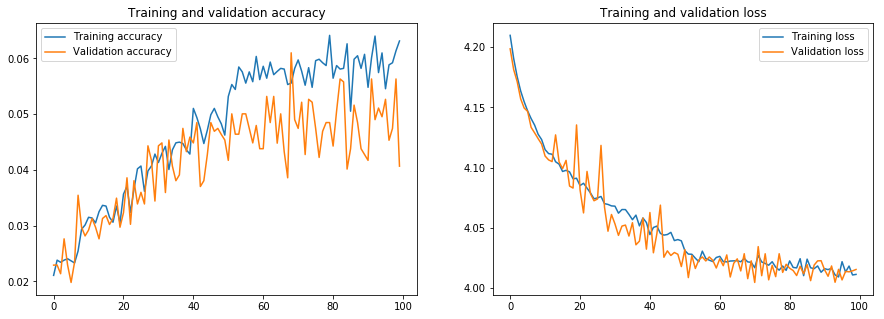

For alpha = 0.125:
 Max test accuracy = 0.1356



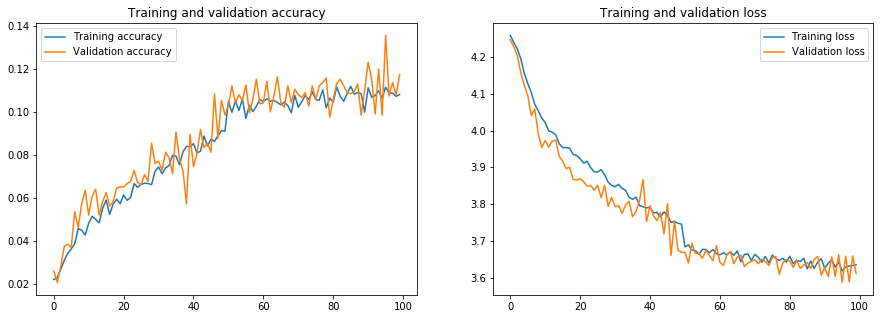

For alpha = 0.25:
 Max test accuracy = 0.121



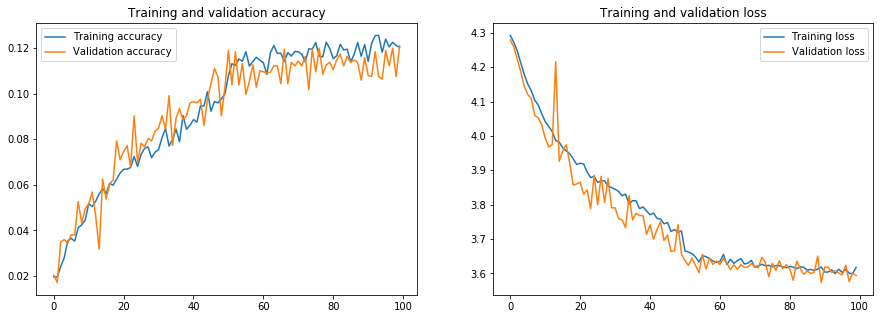

For alpha = 0.5:
 Max test accuracy = 0.1251



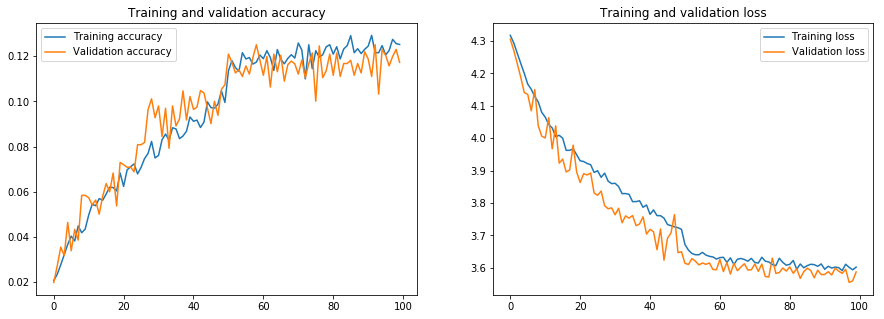

For alpha = 0.75:
 Max test accuracy = 0.1345



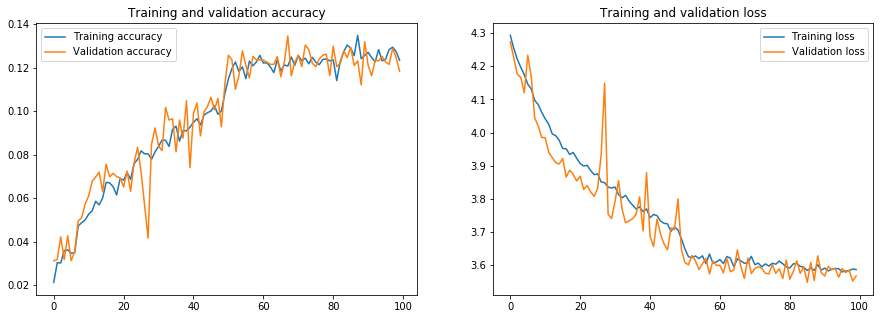

In [8]:
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'nin_dogs_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        print(f"For alpha = {alpha}:\n Max test accuracy = {max(history['val_acc']):.04}\n")

    plot_accuracy_and_loss(history)

In [9]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

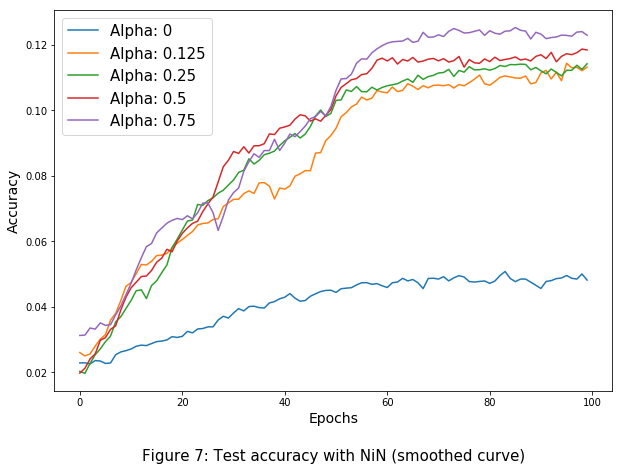

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'nin_dogs_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        ax.plot(smooth_curve(history['val_acc'][:100]), label=f"Alpha: {alpha}", )

ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title("Figure 7: Test accuracy with NiN (smoothed curve)", size=15, y=-0.2)
ax.legend(prop={'size': 15})

plt.show()

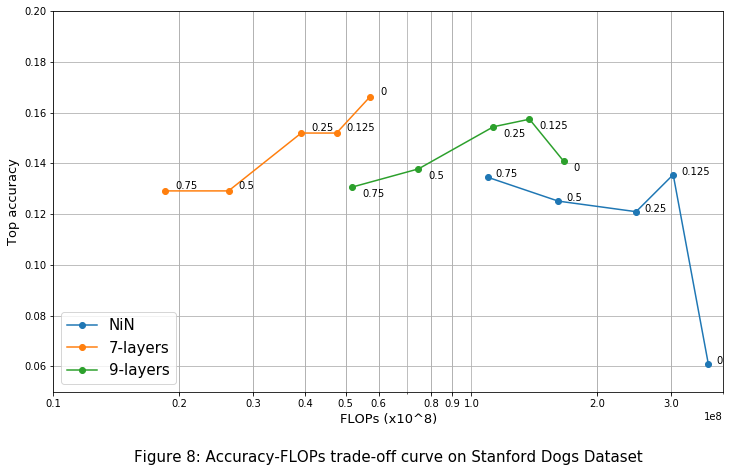

In [31]:
import matplotlib.ticker

nin_acc = []
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'nin_dogs_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        nin_acc.append(max(history['val_acc']))
nin_flops = [368762880, 303941280, 247762560, 161333760, 109476480]

layers_7_acc = []
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'7_layers_dogs_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        layers_7_acc.append(max(history['val_acc']))
layers_7_flops = [57255414, 47561334, 39159798, 26234358, 18479094]

layers_9_acc = []
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'9_layers_dogs_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        layers_9_acc.append(max(history['val_acc']))
layers_9_flops = [166351094, 137709494, 112886774, 74697974, 51784694]

fig, ax = plt.subplots(figsize=(12, 7))

ax.grid(True, which="both")
ax.semilogx(nin_flops, nin_acc, label="NiN", marker='o')
ax.semilogx(layers_7_flops, layers_7_acc, label="7-layers", marker='o')
ax.semilogx(layers_9_flops, layers_9_acc, label="9-layers", marker='o')
ax.set_xlim([10000000, 400000000])
ax.set_ylim([0.05, .2])
ax.set_xlabel('FLOPs (x10^8)', size=13)
ax.set_ylabel('Top accuracy', size=13)
ax.legend(loc='lower left', prop={'size': 15})
ax.set_xticks([1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 8e7, 9e7, 1e8, 2e8, 3e8])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

size = fig.get_size_inches()*fig.dpi # get fig size in pixels
ax.set_title('Figure 8: Accuracy-FLOPs trade-off curve on Stanford Dogs Dataset', y=-0.2, size=15)

for i, alpha in enumerate([0, 0.125, 0.25, 0.5, 0.75]):
    ax.annotate(f"{alpha}", (nin_flops[i], nin_acc[i]), xytext=(8, 0), textcoords='offset points')
    ax.annotate(f"{alpha}", (layers_7_flops[i], layers_7_acc[i]), xytext=(10, 2), textcoords='offset points')
    ax.annotate(f"{alpha}", (layers_9_flops[i], layers_9_acc[i]), xytext=(10, -10), textcoords='offset points')


plt.show()